<a href="https://colab.research.google.com/github/NikhithaVarma/ML-Algos/blob/main/Imbalanced_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd

df=pd.read_csv("train.csv")
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9.0,1.0,5.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0
1,9,0,1,1,7,0,0,0,0,1,...,3.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,0.0
2,13,0,5,4,9,1,0,0,0,1,...,4.0,2.0,7.0,7.0,0.0,1.0,1.0,0.0,1.0,0.0
3,16,0,0,1,2,0,0,1,0,0,...,2.0,2.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,0,0,2,0,1,0,1,0,0,...,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0


In [4]:
target_count=df.target.value_counts()
target_count

0    98951
1     3765
Name: target, dtype: int64

Proportion of class 0 is  96.33 %


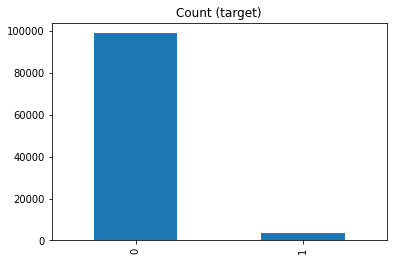

In [5]:
print('Proportion of class 0 is ', round(target_count[0] * 100 / (target_count[1] + target_count[0]), 2),'%')

target_count.plot(kind='bar', title='Count (target)');

In [6]:
df.shape

(102716, 59)

# The metric trap

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#remove id and target columns
labels=df.columns[2:]
df=df.dropna()

X=df[labels]
y=df["target"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

model=DecisionTreeClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [8]:
acc=accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" % (acc * 100.0))

Accuracy: 91.69%


Now let's run the same code, but using only one feature (which should drastically reduce the accuracy of the classifier):

In [9]:
model=DecisionTreeClassifier()
model.fit(X_train[['ps_ind_02_cat']],y_train)
y_pred=model.predict(X_test[['ps_ind_02_cat']])

In [10]:
acc=accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" % (acc * 100.0))

Accuracy: 96.35%


# Confusion matrix

Confusion matrix:
 [[19794     0]
 [  749     0]]


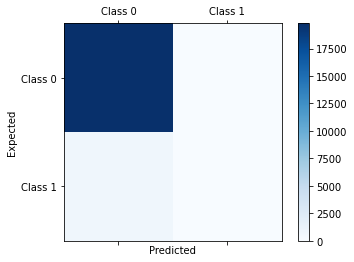

In [11]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, model.predict_proba(X_test[['ps_ind_02_cat']])[:, 1])

0.5092100504353722

# Resampling

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

In [14]:
# Class count
count_class_0, count_class_1 = df.target.value_counts()

# Divide by class
df_class_0 = df[df['target'] == 0]
df_class_1 = df[df['target'] == 1]

count_class_0, count_class_1

(98950, 3765)

**Random under-sampling**

Random under-sampling:
0    3765
1    3765
Name: target, dtype: int64


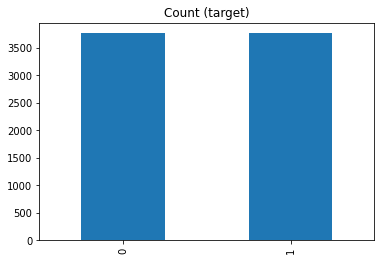

In [15]:
df_class_0_under = df_class_0.sample(count_class_1) #it will randomly sample count_class_1 number of rows from the dataframe
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

**Random over-sampling**

Random over-sampling:
0    98950
1    98950
Name: target, dtype: int64


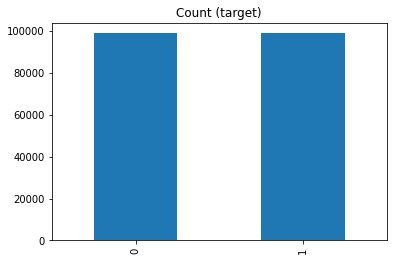

In [16]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

**Python imbalanced-learn module**

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [17]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import imblearn

For ease of visualization, let's create a small unbalanced sample dataset using the make_classification method:

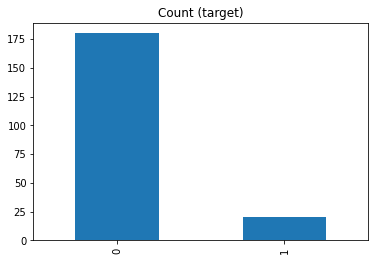

In [19]:
from sklearn.datasets import make_classification #subpackage used for creating own classifcation dataset
import pandas as pd

#generate some fake classification dataset
X, y = make_classification(
    n_classes=2, class_sep=0.75, weights=[0.9, 0.1],
    n_informative=2, n_redundant=0, flip_y=0,
    n_features=2, n_clusters_per_class=2,
    n_samples=200, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
#df
df.target.value_counts().plot(kind='bar', title='Count (target)');

In [20]:
df

,0,1,target
0,0.157423,-0.374667,0
1,-0.909752,0.037925,0
2,-0.944869,-1.136125,0
3,-0.883279,-1.362500,0
4,-0.022943,1.015924,0
...,...,...,...
195,-0.272900,0.923791,0
196,-0.880549,-0.633844,0
197,-1.186294,0.943099,0
198,-1.158688,-0.399660,0


We will also create a 2-dimensional plot function, plot_2d_space, to see the data distribution:



In [21]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

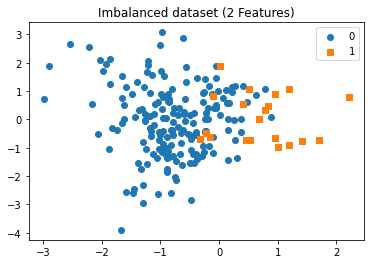

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plot_2d_space(X, y, 'Imbalanced dataset (2 Features)')

**Random under-sampling and over-sampling with imbalanced-learn**

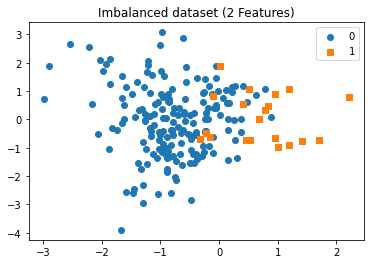

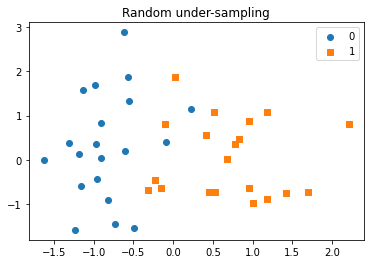

In [23]:
from imblearn.under_sampling import RandomUnderSampler #  import 

rus = RandomUnderSampler() #Intialise the model
X_rus, y_rus = rus.fit_resample(X, y) #resampling the data 

#print('Removed indexes:', id_rus)

plot_2d_space(X, y, 'Imbalanced dataset (2 Features)')
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

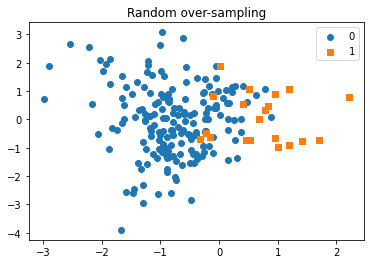

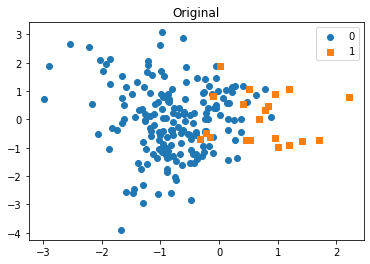

In [25]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler() #Initialis the model 
X_ros, y_ros = ros.fit_resample(X, y) #Fit the model

#print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')
plot_2d_space(X, y, 'Original')

In [26]:
y_ros.sum(), y.sum(), y_rus.sum()

(180, 20, 20)

**Under-sampling: Cluster Centroids**

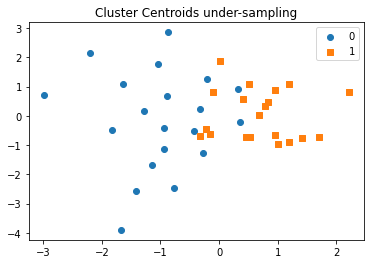

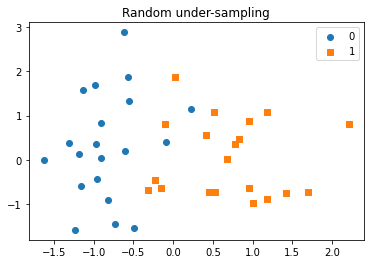

In [27]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy={0: 20})
X_cc, y_cc = cc.fit_resample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')
#plot_2d_space(X, y, 'Original')
plot_2d_space(X_rus, y_rus, 'Random under-sampling')

**Over-sampling: SMOTE**

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

 ![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

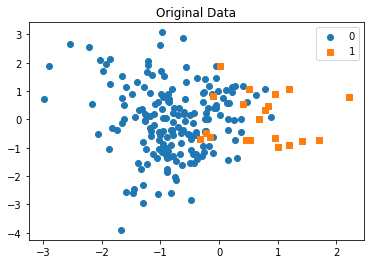

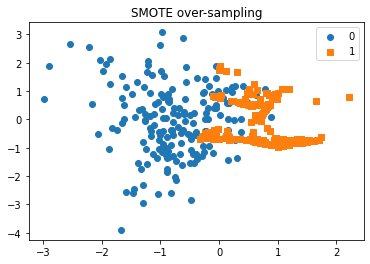

In [28]:
from imblearn.over_sampling import SMOTE

plot_2d_space(X, y, 'Original Data')

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

**Over-sampling followed by under-sampling**

Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:

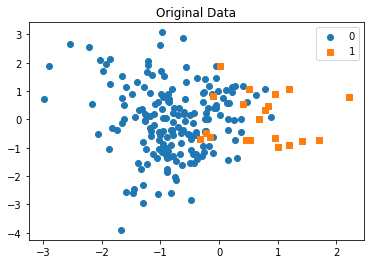

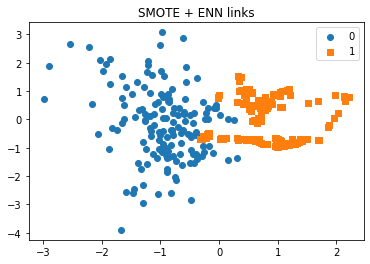

In [29]:
from imblearn.combine import SMOTEENN

plot_2d_space(X, y, 'Original Data')

smt = SMOTEENN(sampling_strategy='all')
X_smt, y_smt = smt.fit_resample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + ENN links')

In [30]:
y_smt.shape

(307,)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression()
lr.fit(X_smt,y_smt)
lr.score(X,y)


print( "AUROC on the sampled dataset : ",roc_auc_score(y, lr.predict_proba(X)[:, 1]))

AUROC on the sampled dataset :  0.9491666666666667
